In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
import soundfile as sf
import sounddevice as sd

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

In [2]:
current_dir = os.getcwd()
base_dir = os.path.dirname(current_dir)

In [3]:
num_labels=20

In [4]:
def augment_audio(audio, sample_rate):
    pitch_shifted = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=np.random.uniform(-2, 2))
    time_stretched = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))
    noise = np.random.randn(len(audio))
    noise_added = audio + 0.005 * noise
    
    return [pitch_shifted, time_stretched, noise_added]

In [5]:
def feature_extractor(file):
    audio, sample_rate = librosa.load(file, res_type="kaiser_fast")
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [6]:
audio_dataset_path = os.path.join(base_dir, "Database/audio")
metadata_path = os.path.join(base_dir, "Database/metadata/BugSounds.csv")
metadata = pd.read_csv(metadata_path)

In [6]:
metadata

,file_name,bug_name
0,bee.wav,Bee
1,beetle.wav,Beetle
2,bessbeetle.wav,Bess Beetle
3,bumblebee.wav,Bumblebee
4,butterfly.wav,Butterfly
5,clickbeetle.wav,Click Beetle
6,cockroach.wav,Cockroach
7,cricket.wav,Cricket
8,dorbeetle.wav,Dor Beetle
9,dragonfly.wav,Dragonfly


In [7]:
extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), str(row["file_name"]))
    final_class_labels = row["bug_name"]
    data = feature_extractor(file_name)
    extracted_features.append([data, final_class_labels])
    audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    augmented_audios = augment_audio(audio, sample_rate)
    for aug_audio in augmented_audios:
        mfccs_features = librosa.feature.mfcc(y=aug_audio, sr=sample_rate, n_mfcc=20)
        mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
        extracted_features.append([mfccs_scaled_features, final_class_labels])


20it [00:16,  1.20it/s]


In [8]:
extracted_features_df = pd.DataFrame(extracted_features, columns=["features", "bug"])

In [9]:
x = np.array(extracted_features_df["features"].tolist())
y = np.array(extracted_features_df["bug"].tolist())

In [10]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)


In [12]:
model=Sequential()
model.add(Dense(64,input_shape=(20,)))
model.add(Activation("relu"))
model.add(Dropout(0.5))
#Hidden
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))
#output
model.add(Dense(num_labels))
model.add(Activation("softmax"))

C:\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=Adam(learning_rate=0.001))

In [14]:
epochscount=1000
num_batch_size=4

In [15]:
model.fit(xtrain, ytrain, batch_size=num_batch_size, epochs=epochscount, validation_data=(xtest, ytest), verbose=1)

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0672 - loss: 88.2561 - val_accuracy: 0.0000e+00 - val_loss: 28.5268
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2466 - loss: 50.1606 - val_accuracy: 0.0000e+00 - val_loss: 19.6668
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1326 - loss: 51.2092 - val_accuracy: 0.1250 - val_loss: 13.9558
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0584 - loss: 37.0515 - val_accuracy: 0.2500 - val_loss: 11.0267
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0715 - loss: 37.9016 - val_accuracy: 0.2500 - val_loss: 8.6961
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0495 - loss: 36.8895 - val_accuracy: 0.2500 - val_loss: 7.4634
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1060 - loss: 28.0136 - val_accuracy: 0.2500 - val_loss: 6.1937
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0649 - loss: 31.69

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0606 - loss: 3.6552 - val_accuracy: 0.0000e+00 - val_loss: 3.0845
Epoch 101/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0992 - loss: 2.9969 - val_accuracy: 0.0000e+00 - val_loss: 3.0856
Epoch 102/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1789 - loss: 2.8514 - val_accuracy: 0.0000e+00 - val_loss: 3.0869
Epoch 103/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0627 - loss: 3.0740 - val_accuracy: 0.0000e+00 - val_loss: 3.0882
Epoch 104/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0534 - loss: 3.3029 - val_accuracy: 0.0000e+00 - val_loss: 3.0890
Epoch 105/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0907 - loss: 2.9373 - val_accuracy: 0.0000e+00 - val_loss: 3.0907
Epoch 106/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0585 - loss: 2.9547 - val_accuracy: 0.0000e+00 - val_loss: 3.0915
Epoch 107/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1752 - lo

Epoch 149/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1148 - loss: 2.9217 - val_accuracy: 0.0000e+00 - val_loss: 3.1357
Epoch 150/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0642 - loss: 2.9383 - val_accuracy: 0.0000e+00 - val_loss: 3.1366
Epoch 151/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1497 - loss: 2.7809 - val_accuracy: 0.0000e+00 - val_loss: 3.1378
Epoch 152/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1141 - loss: 3.2545 - val_accuracy: 0.0000e+00 - val_loss: 3.1380
Epoch 153/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0526 - loss: 3.1031 - val_accuracy: 0.0000e+00 - val_loss: 3.1386
Epoch 154/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0705 - loss: 2.9121 - val_accuracy: 0.0000e+00 - val_loss: 3.1399
Epoch 155/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0904 - loss: 3.0725 - val_accuracy: 0.0000e+00 - val_loss: 3.1406
Epoch 156/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accura

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0802 - loss: 2.6471 - val_accuracy: 0.1250 - val_loss: 2.5319
Epoch 249/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1104 - loss: 2.4652 - val_accuracy: 0.1250 - val_loss: 2.5470
Epoch 250/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1652 - loss: 2.5837 - val_accuracy: 0.1875 - val_loss: 2.5231
Epoch 251/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1089 - loss: 2.6703 - val_accuracy: 0.0625 - val_loss: 2.5495
Epoch 252/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2241 - loss: 2.6468 - val_accuracy: 0.0625 - val_loss: 2.5217
Epoch 253/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1623 - loss: 2.5761 - val_accuracy: 0.1250 - val_loss: 2.4756
Epoch 254/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2050 - loss: 2.4144 - val_accuracy: 0.1875 - val_loss: 2.4256
Epoch 255/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0984 - loss: 2.8494 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1304 - loss: 2.4800 - val_accuracy: 0.2500 - val_loss: 2.1540
Epoch 299/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2323 - loss: 2.4972 - val_accuracy: 0.2500 - val_loss: 2.1303
Epoch 300/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2135 - loss: 2.8864 - val_accuracy: 0.2500 - val_loss: 2.1233
Epoch 301/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2995 - loss: 2.3238 - val_accuracy: 0.2500 - val_loss: 2.1381
Epoch 302/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3104 - loss: 2.1723 - val_accuracy: 0.1875 - val_loss: 2.1426
Epoch 303/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2086 - loss: 2.2553 - val_accuracy: 0.2500 - val_loss: 2.1212
Epoch 304/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2207 - loss: 2.1102 - val_accuracy: 0.2500 - val_loss: 2.1297
Epoch 305/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2945 - loss: 2.3064 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3331 - loss: 2.2004 - val_accuracy: 0.3750 - val_loss: 1.9418
Epoch 349/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1355 - loss: 2.5187 - val_accuracy: 0.3750 - val_loss: 1.9079
Epoch 350/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3502 - loss: 2.0776 - val_accuracy: 0.3750 - val_loss: 1.8855
Epoch 351/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2927 - loss: 2.1455 - val_accuracy: 0.5000 - val_loss: 1.8619
Epoch 352/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1667 - loss: 2.5824 - val_accuracy: 0.4375 - val_loss: 1.8477
Epoch 353/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2656 - loss: 2.4009 - val_accuracy: 0.4375 - val_loss: 1.8643
Epoch 354/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2149 - loss: 2.3644 - val_accuracy: 0.3125 - val_loss: 1.8845
Epoch 355/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3161 - loss: 2.2013 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3743 - loss: 1.6990 - val_accuracy: 0.5000 - val_loss: 1.5149
Epoch 399/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4313 - loss: 1.5380 - val_accuracy: 0.5000 - val_loss: 1.4803
Epoch 400/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3463 - loss: 2.0660 - val_accuracy: 0.5000 - val_loss: 1.4546
Epoch 401/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2957 - loss: 2.1618 - val_accuracy: 0.6250 - val_loss: 1.4377
Epoch 402/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3842 - loss: 2.0069 - val_accuracy: 0.5000 - val_loss: 1.5196
Epoch 403/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3454 - loss: 1.9366 - val_accuracy: 0.5000 - val_loss: 1.5481
Epoch 404/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4160 - loss: 1.9797 - val_accuracy: 0.5000 - val_loss: 1.5979
Epoch 405/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3313 - loss: 1.9991 - val_accuracy: 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3393 - loss: 2.0931 - val_accuracy: 0.6250 - val_loss: 1.3707
Epoch 449/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2972 - loss: 1.8958 - val_accuracy: 0.6250 - val_loss: 1.3722
Epoch 450/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4516 - loss: 1.6926 - val_accuracy: 0.6250 - val_loss: 1.4256
Epoch 451/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3666 - loss: 1.7447 - val_accuracy: 0.5625 - val_loss: 1.4284
Epoch 452/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4149 - loss: 1.6634 - val_accuracy: 0.5625 - val_loss: 1.3925
Epoch 453/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3712 - loss: 1.8320 - val_accuracy: 0.5625 - val_loss: 1.3726
Epoch 454/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4864 - loss: 1.7709 - val_accuracy: 0.6250 - val_loss: 1.3603
Epoch 455/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4185 - loss: 1.6484 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5804 - loss: 1.4435 - val_accuracy: 0.7500 - val_loss: 0.9600
Epoch 499/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4550 - loss: 1.5271 - val_accuracy: 0.7500 - val_loss: 0.9139
Epoch 500/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5599 - loss: 1.5136 - val_accuracy: 0.7500 - val_loss: 0.8933
Epoch 501/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5456 - loss: 1.4473 - val_accuracy: 0.7500 - val_loss: 0.8730
Epoch 502/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6365 - loss: 1.3144 - val_accuracy: 0.7500 - val_loss: 0.8527
Epoch 503/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5113 - loss: 1.6795 - val_accuracy: 0.7500 - val_loss: 0.8232
Epoch 504/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5894 - loss: 1.4130 - val_accuracy: 0.7500 - val_loss: 0.7958
Epoch 505/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5590 - loss: 1.5354 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5197 - loss: 1.2051 - val_accuracy: 0.7500 - val_loss: 0.7383
Epoch 549/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4912 - loss: 1.3741 - val_accuracy: 0.7500 - val_loss: 0.7255
Epoch 550/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6651 - loss: 1.2496 - val_accuracy: 0.8125 - val_loss: 0.7240
Epoch 551/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5381 - loss: 1.2085 - val_accuracy: 0.8750 - val_loss: 0.7133
Epoch 552/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5821 - loss: 1.1952 - val_accuracy: 0.8750 - val_loss: 0.7164
Epoch 553/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5531 - loss: 1.5578 - val_accuracy: 0.8750 - val_loss: 0.7006
Epoch 554/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6310 - loss: 1.3094 - val_accuracy: 0.6875 - val_loss: 0.7653
Epoch 555/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6520 - loss: 1.1818 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5546 - loss: 1.5483 - val_accuracy: 0.7500 - val_loss: 0.6624
Epoch 599/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6486 - loss: 1.1580 - val_accuracy: 0.7500 - val_loss: 0.6834
Epoch 600/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6307 - loss: 1.5308 - val_accuracy: 0.7500 - val_loss: 0.6698
Epoch 601/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5750 - loss: 1.4343 - val_accuracy: 0.7500 - val_loss: 0.6669
Epoch 602/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5472 - loss: 1.3311 - val_accuracy: 0.7500 - val_loss: 0.6552
Epoch 603/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6456 - loss: 1.0684 - val_accuracy: 0.7500 - val_loss: 0.6592
Epoch 604/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5970 - loss: 1.3254 - val_accuracy: 0.7500 - val_loss: 0.6821
Epoch 605/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5626 - loss: 1.3975 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5602 - loss: 1.2395 - val_accuracy: 0.7500 - val_loss: 0.5226
Epoch 649/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7813 - loss: 0.7214 - val_accuracy: 0.8125 - val_loss: 0.5310
Epoch 650/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6241 - loss: 1.1235 - val_accuracy: 0.8125 - val_loss: 0.5361
Epoch 651/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6485 - loss: 1.0103 - val_accuracy: 0.8125 - val_loss: 0.5433
Epoch 652/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6411 - loss: 0.8186 - val_accuracy: 0.8125 - val_loss: 0.5426
Epoch 653/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7174 - loss: 0.9389 - val_accuracy: 0.8125 - val_loss: 0.5495
Epoch 654/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6657 - loss: 1.0902 - val_accuracy: 0.7500 - val_loss: 0.5520
Epoch 655/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6786 - loss: 0.9505 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7319 - loss: 0.7671 - val_accuracy: 0.8750 - val_loss: 0.4407
Epoch 699/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7064 - loss: 1.1404 - val_accuracy: 0.8125 - val_loss: 0.4485
Epoch 700/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7298 - loss: 0.8902 - val_accuracy: 0.8125 - val_loss: 0.4490
Epoch 701/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6978 - loss: 0.7894 - val_accuracy: 0.8125 - val_loss: 0.4346
Epoch 702/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6952 - loss: 1.1356 - val_accuracy: 0.8125 - val_loss: 0.5100
Epoch 703/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5681 - loss: 1.2886 - val_accuracy: 0.7500 - val_loss: 0.4952
Epoch 704/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6293 - loss: 1.0924 - val_accuracy: 0.7500 - val_loss: 0.5354
Epoch 705/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6901 - loss: 0.9932 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8004 - loss: 0.6485 - val_accuracy: 0.9375 - val_loss: 0.3929
Epoch 749/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7461 - loss: 0.9263 - val_accuracy: 0.7500 - val_loss: 0.4539
Epoch 750/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7977 - loss: 0.6711 - val_accuracy: 0.7500 - val_loss: 0.5014
Epoch 751/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7392 - loss: 0.9756 - val_accuracy: 0.7500 - val_loss: 0.5147
Epoch 752/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7123 - loss: 0.7445 - val_accuracy: 0.7500 - val_loss: 0.5290
Epoch 753/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6842 - loss: 0.9844 - val_accuracy: 0.7500 - val_loss: 0.5079
Epoch 754/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7683 - loss: 1.1173 - val_accuracy: 0.7500 - val_loss: 0.5128
Epoch 755/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8661 - loss: 0.6352 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7442 - loss: 0.7583 - val_accuracy: 0.9375 - val_loss: 0.3525
Epoch 799/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7605 - loss: 0.7154 - val_accuracy: 0.8125 - val_loss: 0.4408
Epoch 800/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7420 - loss: 0.8589 - val_accuracy: 0.7500 - val_loss: 0.4792
Epoch 801/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6082 - loss: 1.1356 - val_accuracy: 0.7500 - val_loss: 0.5029
Epoch 802/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6035 - loss: 1.7804 - val_accuracy: 0.7500 - val_loss: 0.4762
Epoch 803/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6813 - loss: 1.0300 - val_accuracy: 0.8750 - val_loss: 0.3811
Epoch 804/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7186 - loss: 0.8959 - val_accuracy: 0.8750 - val_loss: 0.3026
Epoch 805/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7308 - loss: 0.8368 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8737 - loss: 0.3431 - val_accuracy: 0.9375 - val_loss: 0.3802
Epoch 849/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7727 - loss: 1.4501 - val_accuracy: 0.8125 - val_loss: 0.4246
Epoch 850/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5742 - loss: 1.0742 - val_accuracy: 0.8125 - val_loss: 0.3818
Epoch 851/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7763 - loss: 0.6305 - val_accuracy: 0.8750 - val_loss: 0.3394
Epoch 852/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6397 - loss: 0.8550 - val_accuracy: 0.8750 - val_loss: 0.3279
Epoch 853/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6003 - loss: 1.2150 - val_accuracy: 0.8125 - val_loss: 0.4152
Epoch 854/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7552 - loss: 0.7745 - val_accuracy: 0.7500 - val_loss: 0.4847
Epoch 855/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6001 - loss: 1.0108 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6813 - loss: 0.8822 - val_accuracy: 0.9375 - val_loss: 0.1840
Epoch 899/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8286 - loss: 0.7567 - val_accuracy: 1.0000 - val_loss: 0.1509
Epoch 900/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7826 - loss: 0.6664 - val_accuracy: 1.0000 - val_loss: 0.1403
Epoch 901/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7880 - loss: 0.4118 - val_accuracy: 0.9375 - val_loss: 0.1536
Epoch 902/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6420 - loss: 0.8707 - val_accuracy: 0.9375 - val_loss: 0.1490
Epoch 903/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7690 - loss: 0.6718 - val_accuracy: 0.9375 - val_loss: 0.1486
Epoch 904/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7373 - loss: 0.5681 - val_accuracy: 0.9375 - val_loss: 0.1439
Epoch 905/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6133 - loss: 1.1520 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8966 - loss: 0.4672 - val_accuracy: 0.9375 - val_loss: 0.2683
Epoch 949/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7477 - loss: 1.0314 - val_accuracy: 0.9375 - val_loss: 0.2325
Epoch 950/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6750 - loss: 0.7773 - val_accuracy: 0.8750 - val_loss: 0.2452
Epoch 951/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7262 - loss: 0.9057 - val_accuracy: 0.8750 - val_loss: 0.2253
Epoch 952/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7187 - loss: 0.9174 - val_accuracy: 0.8750 - val_loss: 0.2636
Epoch 953/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6915 - loss: 0.9442 - val_accuracy: 0.8750 - val_loss: 0.2825
Epoch 954/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.7334 - val_accuracy: 0.8750 - val_loss: 0.2841
Epoch 955/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8117 - loss: 0.4930 - val_accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7388 - loss: 0.9760 - val_accuracy: 1.0000 - val_loss: 0.1805
Epoch 999/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8176 - loss: 0.6655 - val_accuracy: 0.9375 - val_loss: 0.1928
Epoch 1000/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8409 - loss: 0.5303 - val_accuracy: 0.9375 - val_loss: 0.1894


In [16]:
validation_test_set_accuracy = model.evaluate(xtest, ytest, verbose=0)
print(validation_test_set_accuracy[1])

0.9375


In [17]:
filename = "C:/Users/emre-/Masaüstü/Bug Recognizer Project/Database/audio/wasp.wav"
sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=20)
mfccs_scaled_features = np.mean(mfcc_features.T, axis=0)
mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)

In [18]:
result_array = model.predict(mfccs_scaled_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [19]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)

In [20]:
result_bugs=["Bee","Beetle","Bess Beetle","Bumblebee","Butterfly","Click Beetle","Cockroach","Cricket","Dor Beetle","Dragonfly","Dung Beetle","Grasshopper","House Fly","Katydid","Locust","Long Horn Beetle","Mole Cricket","Mosquito","Moth","Wasp"]

In [21]:
result=np.argmax(result_array[0])

Bug: Wasp 

Wasps are flying insects belonging to the order Hymenoptera, which also includes bees and ants.

Role: Wasps play important roles in ecosystems as predators, helping to control insect populations. Some species are also pollinators, although to a lesser extent than bees. However, some wasps can be pests, particularly those that build nests near human habitation and can sting in defense.

Traits: Typically have slender bodies with a narrow waist, often brightly colored or marked with distinct patterns.

Habitat: Found in various habitats worldwide, including gardens, forests, and urban areas.

Diet: Most adult wasps are predators, feeding on other insects and spiders; some also feed on nectar and sweet substances.



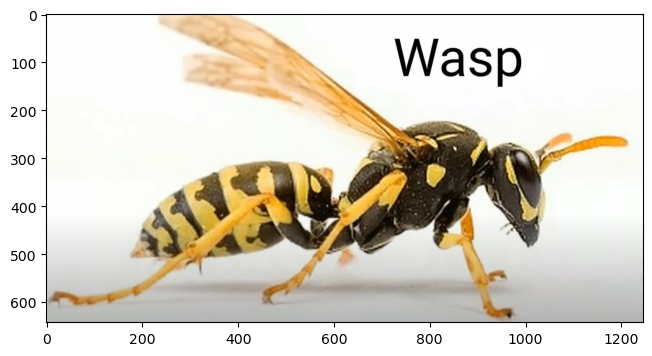

In [22]:
from IPython.display import Audio

if result_bugs[result_recorded]=="Bee":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Bee.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Bees are flying insects closely related to wasps and ants.\n")
    print("Role: Crucial pollinators for many plants and crops.\n")
    print("Honey Production: Honeybees produce honey from nectar.\n")
    print("Social Structure: Many bees live in colonies with a queen, workers, and drones..\n")
    print("Communication: Honeybees use the waggle dance to share information.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/bee.wav")))

elif result_bugs[result_recorded]=="Beetle":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Beetle.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Beetles are insects with hard exoskeletons and forewings called elytra, known for their immense diversity and roles as decomposers, pollinators, and predators.\n")
    print("Role: Key decomposers and pollinators, essential for ecosystems.\n")
    print("Diet: Includes plants, other insects, and decomposing matter.\n")
    print("Habitat: Found almost everywhere.\n")
    print("Diversity: Includes well-known types like ladybugs, fireflies, and dung beetles.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/beetle.wav")))

elif result_bugs[result_recorded]=="Bess Beetle":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Bess Beetle.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Bess beetles are a type of beetle known for their hard bodies and social behavior.\n")
    print("Role: Important decomposers, breaking down wood and recycling nutrients in forest ecosystems.\n")
    print("Traits: Hard exoskeleton and strong mandibles for chewing wood.\n")
    print("Habitat: Found in decaying wood, particularly in forests.\n")
    print("Diet: Feeds on decaying wood and fungi within it.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/bessbeetle.wav")))

elif result_bugs[result_recorded]=="Bumblebee":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Bumblebee.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Bumblebees are robust flying insects closely related to honeybees.\n")
    print("Role:Bumblebees play a crucial role in ecosystems and agriculture by pollinating plants and contributing to biodiversity, making their conservation essential for sustainable food production and natural habitats.\n")
    print("Characteristics: Bumblebees are large, fuzzy insects with round bodies covered in soft hair.\n")
    print("Behavior: Bumblebees are social insects that live in colonies with a queen, workers, and drones.\n")
    print("Habitat: They are found primarily in temperate climates, but some species can also be found in higher altitudes or in tropical regions.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/bumblebee.wav")))
    
elif result_bugs[result_recorded]=="Butterfly":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Butterfly.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Butterflies are colorful flying insects known for their delicate wings and important role in pollination.\n")
    print("Role: Important pollinators contributing to ecosystem health and biodiversity.\n")
    print("Species: Belong to the order Lepidoptera, with numerous species worldwide.\n")
    print("Habitat: Found in diverse habitats, including gardens, meadows, and forests.\n")
    print("Traits: Delicate wings covered in scales, colorful patterns for camouflage and signaling.\n")
    print("Diet: Adults feed on flower nectar; caterpillars feed on host plants.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/butterfly.wav")))

elif result_bugs[result_recorded]=="Click Beetle":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Click Beetle.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Click beetles, scientifically known as Elateridae, are a family of beetles characterized by their ability to flip themselves into the air with an audible clicking sound when placed on their backs.\n")
    print("Role: Click beetles are important decomposers in ecosystems, helping to break down organic matter and recycle nutrients.\n")
    print("Traits: They are characterized by a unique mechanism that allows them to click and flip into the air when placed on their backs, aiding in escaping predators.\n")
    print("Habitat: Click beetles are found in diverse habitats including forests, fields, and gardens.\n")
    print("Diet: As larvae, they feed on decaying plant material and roots. Adults primarily feed on nectar and pollen.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/clickbeetle.wav")))
    
elif result_bugs[result_recorded]=="Cockroach":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Cockroach.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Cockroaches are known for their resilience and adaptability, thriving in various environments worldwide.\n")
    print("Role: Cockroaches play a role in ecosystems as decomposers, breaking down organic matter. However, they are often considered pests due to their presence in human habitats, where they can spread diseases and trigger.\n")
    print("Habitat: Found in various environments, particularly warm and humid areas such as kitchens, bathrooms, and basements.\n")
    print("Diet: Omnivorous scavengers that feed on organic matter, including food scraps, decaying material, and even glue and paper.\n")
    print("Traits: They are characterized by their flattened bodies, long antennae, and a pair of wings that may be either fully developed or reduced.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/cockroach.wav")))

elif result_bugs[result_recorded]=="Cricket":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Cricket.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Crickets are insects belonging to the family Gryllidae, known for their distinctive chirping sounds, which males produce by rubbing their wings together to attract females. \n")
    print("Role: Crickets are important for nutrient cycling, soil health, and serve as prey for many predators.\n")
    print("Habitat: Found in various habitats including fields, forests, gardens, and sometimes inside buildings.\n")
    print("Traits: Crickets have cylindrical bodies, long antennae.\n")
    print("Diet: Omnivorous, feeding on plants, fungi, and small insects.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/cricket.wav")))

elif result_bugs[result_recorded]=="Dor Beetle":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Dor Beetle.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Dor beetles dig tunnels beneath dung piles to lay their eggs, which provides a food source for their larvae.\n")
    print("Role: Important decomposers, aiding in nutrient recycling and soil aeration through their burrowing activities.\n")
    print("Traits: They are stout, dark-colored beetles known for their burrowing behavior.\n")
    print("Habitat: Found in forests, grasslands, and agricultural areas.\n")
    print("Species: Dor beetles belong to the family Geotrupidae, with several species.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/dorbeetle.wav")))

elif result_bugs[result_recorded]=="Dragonfly":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Dragonfly.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Dragonflies are a common subject in art and symbolism, often representing change and transformation.\n")
    print("Role: Important predators of insect populations, helping control pests and contributing to the health of aquatic ecosystems.\n")
    print("Diet: Carnivorous, feeding on other insects, including mosquitoes and flies.\n")
    print("Habitat: Found near freshwater habitats like ponds, lakes, and rivers.\n")
    print("Traits: Dragonflies have elongated bodies, large multifaceted eyes, and two pairs of strong, transparent wings.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/dragonfly.wav")))

elif result_bugs[result_recorded]=="Dung Beetle":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Dung Beetle.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Dung beetles are divided into three main groups based on their behavior: rollers, tunnelers, and dwellers.\n")
    print("Rollers: These beetles shape dung into balls and roll them to a suitable location for burial. This behavior is often associated with mating, as males offer the dung balls to females as a form of courtship.\n")
    print("Tunnelers: These beetles dig tunnels beneath dung piles and bury pieces of dung within these tunnels to provide food and a nesting site for their larvae.\n")
    print("Dwellers: These beetles live directly in dung piles and lay their eggs there, where the larvae develop.\n")
    print("Role: Important decomposers, aiding in nutrient recycling, soil aeration, and reducing parasitic loads in environments.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/dungbeetle.wav")))

elif result_bugs[result_recorded]=="Grasshopper":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Grasshopper.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Grasshoppers can have significant ecological impacts. In large numbers, they can become pests, causing substantial damage to crops and vegetation.\n")
    print("Role: Important in food chains as prey for many animals, and can influence plant community dynamics through their feeding.\n")
    print("Traits: They have long hind legs adapted for jumping, and short antennae.\n")
    print("Habitat: Found in a variety of habitats including grasslands, forests, and agricultural fields.\n")
    print("Species: Grasshoppers belong to the suborder Caelifera, with over 11,000 species worldwide.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/grasshopper.wav")))

elif result_bugs[result_recorded]=="House Fly":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/House Fly.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("House flies can carry and transmit various pathogens, including bacteria, viruses, and parasites, due to their feeding and breeding habits.\n")
    print("Role: Known as pests due to their potential to spread diseases, but also play a role in decomposition and nutrient recycling.\n")
    print("Traits: Small, with a gray thorax, four dark longitudinal stripes on the back, and slightly hairy bodies.\n")
    print("Habitat: Found worldwide, especially in areas with human activity such as homes, farms, and garbage dumps.\n")
    print("Diet: Omnivorous, feeding on decaying organic matter, food waste, and animal feces.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/housefly.wav")))

elif result_bugs[result_recorded]=="Katydid":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Katydid.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Katydid males produce characteristic mating calls by rubbing their wings together, a behavior known as stridulation. These sounds are often described as katy-did or katy-didn't, which is how they got their common name.\n")
    print("Role: Important in ecosystems as both prey and consumers of plant material, contributing to the balance of plant and insect populations.\n")
    print("Traits: Known for their leaf-like appearance, long antennae.\n")
    print("Diet: Mostly herbivorous, feeding on leaves, flowers, and stems; some species are omnivorous.\n")
    print("Habitat: Found in various habitats including forests, grasslands, and gardens.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/katydid.wav")))

elif result_bugs[result_recorded]=="Locust":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Locust.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Locusts are a type of short-horned grasshopper and distinguished by their ability to undergo dramatic behavioral and physiological changes in response to environmental conditions, particularly crowding.\n")
    print("Role: Can have a significant impact on agriculture due to their swarming behavior, causing extensive crop damage and affecting food security.\n")
    print("Traits: Normally solitary, but can form large, destructive swarms under certain conditions; have powerful hind legs for jumping and flying.\n")
    print("Habitat: Found in various environments, including grasslands, deserts, and agricultural areas.\n")
    print("Diet: Herbivorous, feeding on a wide range of plants and crops.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/locust.wav")))
    
elif result_bugs[result_recorded]=="Long Horn Beetle":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Long Horn Beetle.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Longhorn beetles are of interest to scientists and entomologists due to their diverse behaviors, life cycles, and interactions with their environments.\n")
    print("Role: Important decomposers, aiding in the breakdown of dead wood and recycling nutrients in forest ecosystems.\n")
    print("Traits: Characterized by their long antennae, often longer than their bodies, and elongated bodies.\n")
    print("Diet: Larvae feed on wood, while adults feed on leaves, nectar, and bark.\n")
    print("Habitat: Found in forests, woodlands, and areas with abundant dead or decaying wood.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/longhornbeetle.wav")))

elif result_bugs[result_recorded]=="Mole Cricket":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Mole Cricket.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Mole crickets are insects belonging to the family Gryllotalpidae within the order Orthoptera.\n")
    print("Role: Known for aerating soil through their burrowing activities, but can also be pests due to their feeding on plant roots and damaging crops.\n")
    print("Traits: Known for their burrowing behavior, they have strong forelimbs adapted for digging and are typically brown or tan.\n")
    print("Habitat: Found in moist soil environments, including lawns, gardens, and agricultural fields.\n")
    print("Diet: Omnivorous, feeding on roots, tubers, and other plant material, as well as small insects and larvae.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/molecricket.wav")))

elif result_bugs[result_recorded]=="Mosquito":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Mosquito.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Mosquitoes are small, flying insects known for their ability to feed on the blood of animals, including humans, using specialized mouthparts called proboscis.\n")
    print("Role: While some species serve as pollinators, females are known for their role as vectors of diseases such as malaria, dengue fever, Zika virus, and West Nile virus, posing significant health risks to humans and animals alike.\n")
    print("Traits: Small flying insects with slender bodies, long legs, and a characteristic proboscis for feeding.\n")
    print("Habitat: Found in various habitats worldwide, especially where standing water is present, such as marshes, ponds, and urban areas.\n")
    print("Diet: Females feed on blood to obtain proteins necessary for egg development; males feed on nectar and other plant fluids.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/mosquito.wav")))

elif result_bugs[result_recorded]=="Moth":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Moth.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Moths belong to the order Lepidoptera, which also includes butterflies. They are diverse insects known for their typically dull-colored wings, although some species are brightly colored or patterned.\n")
    print("Role: Moths play important roles in ecosystems as pollinators for many plants, contributors to food webs as prey for birds and other animals, and some species are economically important as pests of crops and stored products.\n")
    print("Traits: Typically have thick bodies, feathery or filamentous antennae (compared to the clubbed antennae of butterflies), and usually rest with their wings spread out.\n")
    print("Habitat: Found in diverse habitats worldwide, including forests, fields, and urban areas.\n")
    print("Diet: As larvae (caterpillars), moths feed on a variety of plant materials; as adults, they primarily feed on nectar.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/moth.wav")))

elif result_bugs[result_recorded]=="Wasp":
    print("Bug:", result_bugs[result_recorded],"\n" )
    import matplotlib.image as mpimg
    plt.figure(figsize=(12,4))
    img = mpimg.imread(os.path.join(base_dir, "Database/image/Wasp.jpg"))
    imgplot = plt.imshow(img)
    plt.show
    print("Wasps are flying insects belonging to the order Hymenoptera, which also includes bees and ants.\n")
    print("Role: Wasps play important roles in ecosystems as predators, helping to control insect populations. Some species are also pollinators, although to a lesser extent than bees. However, some wasps can be pests, particularly those that build nests near human habitation and can sting in defense.\n")
    print("Traits: Typically have slender bodies with a narrow waist, often brightly colored or marked with distinct patterns.\n")
    print("Habitat: Found in various habitats worldwide, including gardens, forests, and urban areas.\n")
    print("Diet: Most adult wasps are predators, feeding on other insects and spiders; some also feed on nectar and sweet substances.\n")
    display(Audio(os.path.join(base_dir, "Database/audio/wasp.wav")))